In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts,StepLR, OneCycleLR

torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
mu = 0
sigma = 1
a = 10
T = 1
epsilon = 0.001
num_samples = 2000

t = torch.arange(0, T+epsilon, epsilon)

y_mean = a * t
variance = sigma**2 * t * (1 - t/T)
std_dev = torch.sqrt(variance)

upper_bound = y_mean + 3 * std_dev
lower_bound = y_mean - 3 * std_dev

def f(t, y):
    return (a * T - y) / (T - t)

In [3]:
import numpy as np
import plotly.graph_objects as go


# 生成t和y的网格
t = np.linspace(0.00, 0.999, num_samples)  # 避免t=T的情况，这里我们把范围设置为0.01到0.99
y = np.linspace(-2, 15, num_samples)
t, y = np.meshgrid(t, y)

# 计算每一个网格点上的函数值
z = f(t, y)

In [4]:

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=2, hidden_dim=64):
        super(MLP, self).__init__()
        
        self.fcin = nn.Linear(input_dim, hidden_dim)
        self.fcs = nn.ModuleList()
        for i in range(hidden_layers):
            self.fcs.append(nn.Linear(hidden_dim, hidden_dim))
        self.fcout = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        ret = self.fcin(x)
        ret = self.relu(ret)
        for fc in self.fcs:
            ret = fc(ret)
            ret = self.relu(ret)
        ret = self.fcout(ret)
        return ret

class BBdataset(Dataset):
    def __init__(self, data):
        self.data = data  
        
    def __len__(self):
        return len(self.data)  
    
    def __getitem__(self, index):
        return self.data[index, :].reshape(1, -1)

In [38]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    
    for training_data in train_dl:
        x, score = training_data[:, :, 0:2], training_data[:, :, -1:]
        x = x.to(device)
        score = score.to(device)

        pred = model(x)
        loss = loss_fn(pred, score)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

t_flat = t.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# 组合成data
data = np.stack((t_flat, y_flat, z_flat), axis=1)
raw_data = torch.Tensor(data)
train_ds = BBdataset(raw_data)
train_dl = DataLoader(train_ds, batch_size=1000, shuffle=True)

model = MLP(input_dim=2, output_dim=1, hidden_layers=4, hidden_dim=128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
epochs = 30
scheduler = OneCycleLR(optimizer, max_lr=0.001, total_steps=epochs*len(train_dl))
loss_fn = nn.MSELoss()
loss_list = []
print('='*10+'model'+'='*10)
print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
print(model)

==========model==========
batch_szie:1000, channel:1, length:3
MLP(
  (fcin): Linear(in_features=2, out_features=128, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
model.train()
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, scheduler, loss_fn)
    loss_list.append(now_loss)
    cur_lr = optimizer.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))

epoch_iterator.close()

Training (lr: X)  (loss= X):   0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x1 and 2x128)

In [40]:
torch.save(model.state_dict(), 'best.pt')


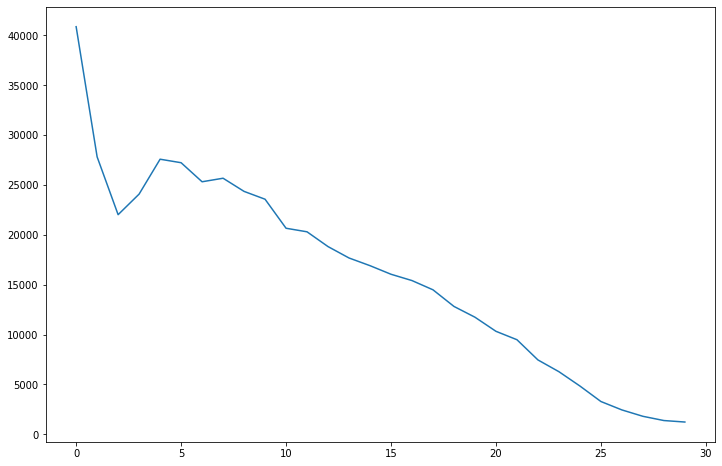

In [11]:
# draw the loss_list for the loss graph
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(epochs), loss_list)
fig.show()

No handles with labels found to put in legend.


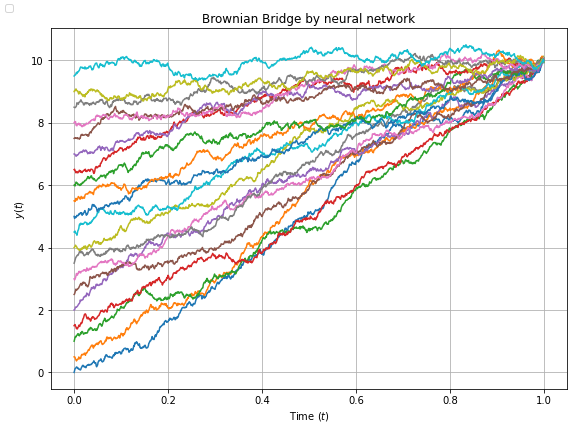

In [37]:
# Test model

test_num_samples = 20
model = model.cpu()
model.eval()
epsilon = 0.001
test_t = torch.arange(0, T+epsilon, epsilon)
preds = torch.zeros((test_t.shape[0], test_num_samples))

pred_bridge = torch.ones((test_t.shape[0], test_num_samples))
pred_bridge[0, :] = torch.Tensor(range(0, 20)) / 2 
for i in range(len(test_t) - 1):
    dt = test_t[i+1] - test_t[i]      # dt = epsilon
    with torch.no_grad():
        x = torch.concat([test_t[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1), pred_bridge[i].reshape(-1, 1, 1)], axis=-1)
        # print(x.shape)
        dydt = model(x)
        # print(dydt.shape)
    dydt = dydt[:, 0, 0]
    preds[i, :] = dydt
    diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples)
    pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion
    # pred_bridge[i+1, :] += 
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(test_t, pred_bridge)
# ax.plot(test_t, y_mean, label=r'<y>', linewidth=2, color='black', alpha=0.5)
# ax.plot(test_t, lower_bound, color='orange', linewidth=1, label='Brownian Bridge lower_bound')
# ax.plot(test_t, upper_bound, color='orange', linewidth=1, label='Brownian Bridge upper_bound')


ax.set_title('Brownian Bridge by neural network')
ax.set_xlabel('Time ($t$)')
ax.set_ylabel('$y(t)$')
ax.grid(True)
fig.legend(loc='upper left')
fig.tight_layout()

plt.savefig('outs/brownian_bridge_pred.jpg', dpi=300)
# writer.add_image('images', fig, 0)

plt.show()